In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions


In [2]:
train_data_path = os.path.join('..', 'Dataset', 'data', 'train') # '/content/data/train'
valid_data_path = os.path.join('..', 'Dataset', 'data', 'test') # '/content/data/test'

train_data_agumentation = ImageDataGenerator(rescale = 1./255,
                                            #  shear_range = 0.2,
                                             zoom_range = 0.1
                                            #  horizontal_flip = True,
                                            #  vertical_flip = True
                                             )

val_data_agumentation = ImageDataGenerator(rescale = 1./255)


# load training data
train_data = train_data_agumentation.flow_from_directory(directory = train_data_path,
                                                         target_size = (224,224),
                                                         class_mode = 'categorical',
                                                         batch_size = 32)

val_data = val_data_agumentation.flow_from_directory(directory = valid_data_path,
                                                     target_size = (224,224),
                                                     class_mode = 'categorical',
                                                     batch_size = 32)

Found 1206 images belonging to 3 classes.
Found 594 images belonging to 3 classes.


In [3]:
checkpoint_dir = 'checkpoints_vgg16_SGD'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir,
                                   "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}_val_loss_{val_loss:.2f}.keras")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto')

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 10,
                      verbose = 0,
                      mode = 'auto')

reduceLR = ReduceLROnPlateau(monitor="val_loss", 
                             factor=0.1,
                             patience=10, 
                             verbose=0, 
                             mode="auto",
                             min_delta=0.0001, 
                             cooldown=0,
                             min_lr=0.0)

csv_logger = CSVLogger('training.log')

callbacks_list = [checkpoint, reduceLR, csv_logger] #, early


In [4]:
image_size = [224, 224]
num_classes = len(glob.glob(train_data_path+'/*'))

# Load the pre-trained model
model = VGG16(input_shape = image_size + [3],
              weights = 'imagenet',
              include_top = False)

# our layers - you can add more if you want
x = Flatten()(model.output)

output_layer = Dense(num_classes, activation='softmax')(x)

# model.layers.trainable = False
for layer in model.layers:
    layer.trainable = False

# create a model object
model = Model(inputs = model.input, outputs = output_layer)
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
#Initializing the hyperparameters
sgd = SGD(learning_rate = 0.01, 
          momentum = 0.9, 
          nesterov = False)

# compile the model with adam optimizer, categorical_croosentropy loss function
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [6]:
history = model.fit(train_data,
                    batch_size = 32,
                    epochs = 10,
                    validation_data = val_data,
                    callbacks = callbacks_list)

# steps_per_epoch=len(training_set),
# validation_steps=len(test_set),

# model.save('VGG16_SGD_model_last_epoch.h5')
# Save the trained model
save_model_path = os.path.join(checkpoint_dir, 'VGG16_SGD_model_last_epoch.h5')
model.save(save_model_path)
print(f"Model saved as {save_model_path}.")

Epoch 1/10


38/38 [==============================] - 503s 13s/step - loss: 33.8337 - accuracy: 0.3723 - val_loss: 42.0120 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 2/10
38/38 [==============================] - 1157s 31s/step - loss: 27.6144 - accuracy: 0.3831 - val_loss: 10.0423 - val_accuracy: 0.4512 - lr: 0.0100
Epoch 3/10
38/38 [==============================] - 458s 12s/step - loss: 13.0117 - accuracy: 0.4768 - val_loss: 12.0602 - val_accuracy: 0.4108 - lr: 0.0100
Epoch 4/10
38/38 [==============================] - 445s 12s/step - loss: 17.0291 - accuracy: 0.4403 - val_loss: 15.4458 - val_accuracy: 0.4832 - lr: 0.0100
Epoch 5/10
38/38 [==============================] - 431s 11s/step - loss: 15.7280 - accuracy: 0.4652 - val_loss: 5.6925 - val_accuracy: 0.6128 - lr: 0.0100
Epoch 6/10
38/38 [==============================] - 464s 12s/step - loss: 7.4875 - accuracy: 0.5837 - val_loss: 5.9589 - val_accuracy: 0.6128 - lr: 0.0100
Epoch 7/10
38/38 [==============================] - 463s 1

C:\ProjectWork\Basic_Python\Suresh Interview Project\Project_Multi_Cancer\venv_multican\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


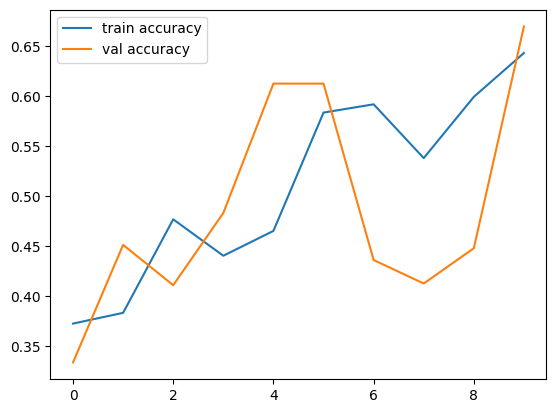

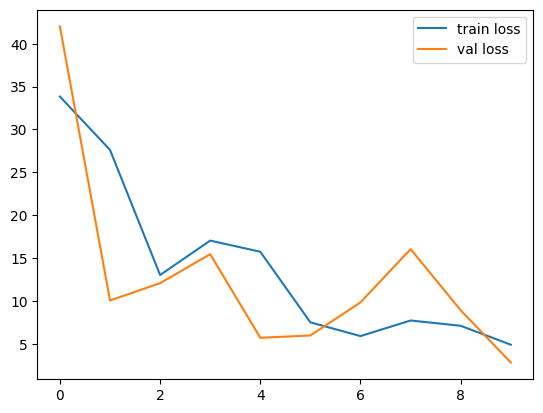

In [7]:
# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [8]:
score = model.evaluate(train_data, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 2.1578543186187744
Train accuracy: 0.7271973490715027


In [9]:
score = model.evaluate(val_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.808372974395752
Test accuracy: 0.6700336933135986


# Create Classification Report

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Found 4200 images belonging to 3 classes.
132/132 [==============================] - 952s 7s/step
Confusion Matrix:
 [[ 752  406  242]
 [  77 1181  142]
 [ 206  500  694]]

Accuracy Score: 62.55%

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.54      0.62      1400
           1       0.57      0.84      0.68      1400
           2       0.64      0.50      0.56      1400

    accuracy                           0.63      4200
   macro avg       0.65      0.63      0.62      4200
weighted avg       0.65      0.63      0.62      4200

Cohen's Kappa Score: 0.4382


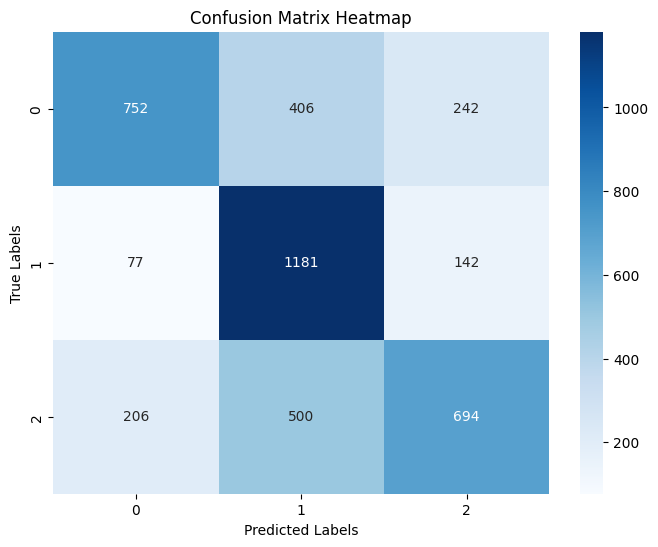

In [11]:
# Create Classification Report

def evaluate_model(y_true, y_pred, class_names=None):
    """
    This function evaluates the performance of a model and prints the confusion matrix, 
    accuracy score, classification report, and Cohen's kappa score. It also plots a heatmap of the confusion matrix.
    
    Args:
        y_true (array-like): Ground truth (true labels)
        y_pred (array-like): Predicted labels from the model
        class_names (list): List of class names for better readability in the confusion matrix
        
    Returns:
        None: Displays the evaluation metrics and heatmap.
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true, y_pred)
    
    # Get classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    
    # Calculate Cohen's kappa score
    kappa_score = cohen_kappa_score(y_true, y_pred)
    
    # Print evaluation metrics
    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Score: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", class_report)
    print(f"Cohen's Kappa Score: {kappa_score:.4f}")
    
    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


def create_classification_report(model_path, test_data_dir):
    # Step 1: Set up directories and parameters
    # test_data_dir = 'data/train/'  # Path to the directory containing test images in folders 0, 1, 2

    # Step 2: Load the trained model
    model = load_model(model_path)  # Assuming you've saved the model as .h5

    # Step 3: ImageDataGenerator for loading test images (no augmentation needed for testing)
    test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

    # Step 4: Load test data using flow_from_directory
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (224, 224),  # Same size as the input size for your model
        batch_size = 32,  # Adjust according to your hardware
        class_mode = 'categorical',  # For multi-class classification
        shuffle = False  # Don't shuffle, we need to keep track of the order for y_true
    )

    # Step 5: Get true labels from the generator
    y_true = test_generator.classes  # These are the true class labels

    # Step 6: Predict using the model
    y_pred_prob = model.predict(test_generator)  # Predict probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the max probability (class label)

    # Step 7: Map predicted and true labels to class names
    class_labels = list(test_generator.class_indices.keys())

    # You can use the evaluation function from earlier for further analysis
    evaluate_model(y_true, y_pred, class_names=class_labels)
    
# Call the function

model_path = os.path.join(checkpoint_dir, 'VGG16_SGD_model_last_epoch.h5')
test_data_dir = os.path.join('..', 'Dataset', 'data', 'val1')

create_classification_report(model_path, test_data_dir)